Modelado del PIB Turìstico Total usando la Cuenta Satèlite del Turismo de Mèxico (INEGI).
El archivo contiene series anuales del PIB turìstico y sus componentes (bienes, servicios y subramas) en millones de pesos, a precios corrientes y a precios constantes 2018. La variable categoria_detalle codifica una jerarquìa tipo Total del país | Total turístico | (Bienes/Servicios) | (Subrama).

Objetivo: Construir un modelo de regresiòn que explique el PIB turìstico total a partir de sus componentes y su estructura, comparando un modelo lineal (OLS) con un modelo no lineal (polinòmico grado 2).

Metodologìa:
Limpieza de datos, huecos (interpolaciòn/mediana, outliers (capado IQR), cualitativas (jerarquìa), colinealidad (no usar "Total" como X, uso de hares, eliminaciòn de dependencias perfectas), e interacciones (en el modelo  polinòmico).
Selecciòn de caracterìsticas (eliminaciòn hacia atràs por p-values).
Estimacion de modelos lineal y no lineal, evaluacion (RMSE, R²) y màrgenes de error (IC/IP) para inferencia.

Se carga numpy, pandas, matplotlib, seaborn y statsmodels, son las herramientas estàndar de manipulaciòn de datos, visualizaciòn y regresiòn. EL estilo consistente facilita interpretar resultados y reproducir el anàlisis.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
sns.set(style="whitegrid", rc={'figure.figsize':(10,5)})


Se lee el archivo CSV, imprime dimensiones/ columnas y se muestra una vista de los 10 iniciales. Garantiza que el insumo existe y es legible antes de continuar. Mostrar columnas y primeras filas permite verificar que la estructura esta correcta (años, tipo de precio, categorìa, valor).

In [216]:
import os

candidatos = ["pib_turismo.csv"]

df = None
for c in candidatos:
    if os.path.exists(c):
        df = pd.read_csv(c, low_memory=False)
        print(" Archivo cargado:", c, "| Shape:", df.shape)
        break

if df is None:
    raise FileNotFoundError("No encontré el archivo pib_turismo.csv en la carpeta.")

print("Columnas:", df.columns.tolist())
display(df.head(10))


 Archivo cargado: pib_turismo.csv | Shape: (1860, 5)
Columnas: ['anio', 'tipo_precio', 'unidad_medida', 'categoria_detalle', 'valor_millones_pesos']


,anio,tipo_precio,unidad_medida,categoria_detalle,valor_millones_pesos
0,1993,corrientes,Millones de pesos a precios corrientes,Total del país,"1,585,848.1390"
1,1993,corrientes,Millones de pesos a precios corrientes,Total del país|Total turístico,"172,419.6690"
2,1993,corrientes,Millones de pesos a precios corrientes,Total del país|Total turístico|Bienes,"23,123.4230"
3,1993,corrientes,Millones de pesos a precios corrientes,Total del país|Total turístico|Bienes|Artesanías,"10,674.6290"
4,1993,corrientes,Millones de pesos a precios corrientes,Total del país|Total turístico|Bienes|Otros bi...,"12,448.7940"
5,1993,corrientes,Millones de pesos a precios corrientes,Total del país|Total turístico|Servicios,"149,296.2460"
6,1993,corrientes,Millones de pesos a precios corrientes,Total del país|Total turístico|Servicios|Servi...,"1,920.7100"
7,1993,corrientes,Millones de pesos a precios corrientes,Total del país|Total turístico|Servicios|Servi...,251.9570
8,1993,corrientes,Millones de pesos a precios corrientes,Total del país|Total turístico|Servicios|Servi...,545.4310
9,1993,corrientes,Millones de pesos a precios corrientes,Total del país|Total turístico|Servicios|Servi...,"13,795.5580"


Filtra registros con tipo_precio == 'consantes_2018', convierte anio y valor a numèricos y calcula resùmenes iniciales (rango temporal, conteos, categorìas principales por valor). Usar precios constantes elimina el efecto de la inflaciòn, permitiendo comparar variaciòn real. La exploraciòn inicial confirma cobertura y ayuda a eleir componentes relevantes màs adelante.

In [232]:
dfc = df.query("tipo_precio == 'constantes_2018'").copy()

dfc['anio'] = pd.to_numeric(dfc['anio'], errors='coerce').astype(int)
dfc['valor_millones_pesos'] = pd.to_numeric(dfc['valor_millones_pesos'], errors='coerce')

print("Años disponibles:", dfc['anio'].min(), "→", dfc['anio'].max())
print("Observaciones totales:", len(dfc))

top_cats = (dfc.groupby('categoria_detalle')['valor_millones_pesos']
              .sum().sort_values(ascending=False).head(12))
display(top_cats)

Años disponibles: 1993 → 2023
Observaciones totales: 930


categoria_detalle
Total del país                                                                                                                              578,741,463.5000
Total del país|Total turístico                                                                                                               52,789,698.3010
Total del país|Total turístico|Servicios                                                                                                     43,535,883.8280
Total del país|Total turístico|Servicios|Otros servicios                                                                                     13,582,434.9990
Total del país|Total turístico|Servicios|Restaurantes, bares y centros nocturnos<C1>                                                         10,150,020.0540
Total del país|Total turístico|Bienes                                                                                                         9,253,814.4730
Total del país|Total turístico|Servicios

Se define funciones auxiliares para trabajar con la jerarquìa de categorìas de manera robusta. Porque en datos oficiales, pequeñas variaciones (“Turístico” vs “Turistico”, “país” vs “pais”) rompen filtros. Se evita errores por texto y garantiza que los subconjuntos se identifiquen bien.

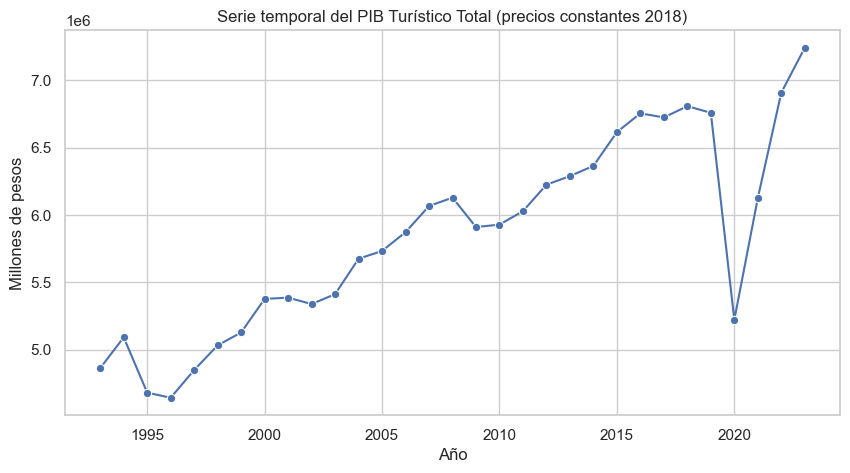

In [233]:
import re
def norm_txt(s):
    if pd.isna(s): return s
    s = s.lower()
    s = (s.replace('á','a').replace('é','e').replace('í','i')
           .replace('ó','o').replace('ú','u'))
    s = re.sub(r'\s+', ' ', s).strip()
    return s

dfc_norm = dfc.copy()
spl = dfc_norm['categoria_detalle'].str.split('|', expand=True)
for i in range(spl.shape[1]):
    dfc_norm[f'nivel{i+1}'] = spl[i].str.strip().map(norm_txt)

mask = (dfc_norm['nivel1']=='total del pais') & (dfc_norm['nivel2']=='total turistico')
scope = dfc_norm.loc[mask].copy()

y_total = scope[scope['nivel3']=='total'].groupby('anio', as_index=True)['valor_millones_pesos'].sum()
if y_total.empty:
    y_total = scope.groupby('anio', as_index=True)['valor_millones_pesos'].sum()

plt.figure(figsize=(10,5))
sns.lineplot(x=y_total.index, y=y_total.values, marker="o")
plt.title("Serie temporal del PIB Turístico Total (precios constantes 2018)")
plt.xlabel("Año"); plt.ylabel("Millones de pesos"); plt.grid(True); plt.show()

Grafica
Muesra la serie temporal de PIB Turìstico Total a precios constantes de 2028 entre 1993 y 2023. Se observa una tendencia creciente de largo plazo, con un choque negativo en 2020 asociado a la pandemia seguramente, seguido de una recuperaciòn ràpida en los años siguientes.

- Justifica el uso de precios constantes (evitamos que el crecimiento refleje solo inflaciòn).
- Muestra la necesidad de considera no linealidades o choques en el  modelado.
- Respalda la decisiòn de incluir el año com variable (temporal).

Reemplaza marcadores de vacio, interpolaciòn temporal por categorìa, si pesistieran huecos, mediana por categorìa. Reporta huecos antes/despues.
INEGI utiliza supresòn por confidencialidad, imputar suavemente en el tiempo mantiene la tendencia de cada categorìa y la mediana evista sesgo cuando falta toda una racha. Esto habilita modelos y mètricas sin romper por NaN.

In [234]:
dfw = dfc.copy()

missing_like = {"", " ", "NA", "N/A", "na", "Null", "null", ".", "..", "...", "-", "--"}
dfw = dfw.replace(list(missing_like), np.nan)

dfw['valor_millones_pesos'] = pd.to_numeric(dfw['valor_millones_pesos'], errors='coerce')

print("Huecos ANTES:", int(dfw['valor_millones_pesos'].isna().sum()))

dfw = dfw.sort_values(['categoria_detalle','anio'])
dfw['valor_millones_pesos'] = (
    dfw.groupby('categoria_detalle', group_keys=False)['valor_millones_pesos']
       .transform(lambda s: s.interpolate(method='linear', limit_direction='both'))
)

medianas = dfw.groupby('categoria_detalle')['valor_millones_pesos'].transform('median')
dfw['valor_millones_pesos'] = dfw['valor_millones_pesos'].fillna(medianas)

print("Huecos DESPUÉS:", int(dfw['valor_millones_pesos'].isna().sum()))

display(dfw.groupby('anio')['valor_millones_pesos'].sum().head(8).to_frame('suma_anual'))


Huecos ANTES: 0
Huecos DESPUÉS: 0


,suma_anual
anio,
1993,"17,979,028.2130"
1994,"18,762,901.8680"
1995,"17,558,793.8140"
1996,"18,334,536.9640"
1997,"19,519,318.3420"
1998,"20,602,181.3400"
1999,"21,119,344.8550"
2000,"22,189,099.7610"


Se aplica capado estilo Tukey (IQR*k) por categorìa a valor_millones_pesos. Porque los choques (como 2020) generan extremos que pueden dominar la estimaciòn. El capado IQR limita su influencia sin elimanr filas, dejando el patròn central de cada categorìa y mejorando la estabilidad del modelo

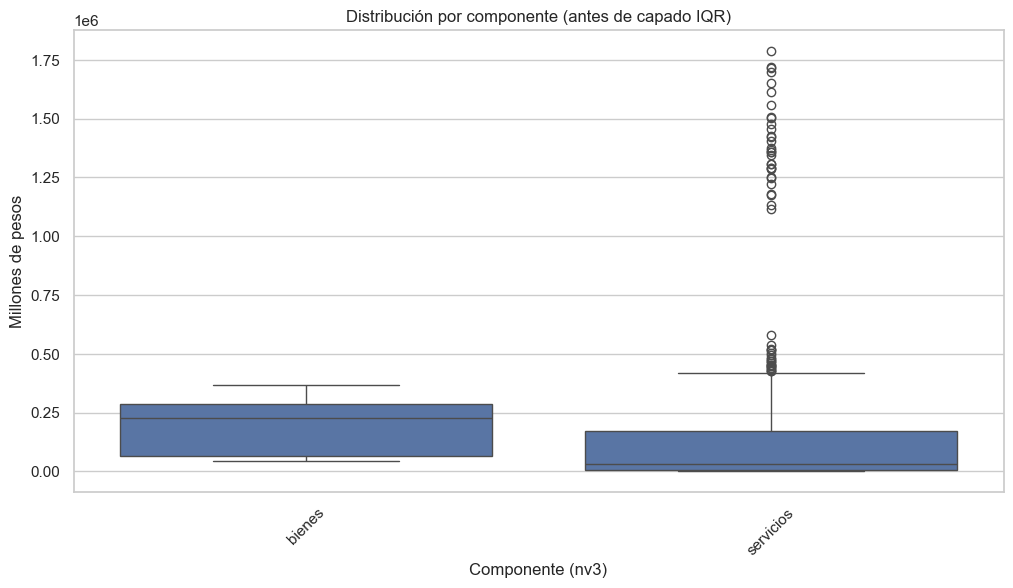

In [235]:
spl_w = dfw['categoria_detalle'].str.split('|', expand=True)
for i in range(spl_w.shape[1]):
    dfw[f'nv{i+1}'] = spl_w[i].str.strip().map(norm_txt)

mask_w = (dfw['nv1']=='total del pais') & (dfw['nv2']=='total turistico')
comp_w = dfw.loc[mask_w & (dfw['nv3']!='total')].copy()

top_components = (comp_w.groupby('nv3')['valor_millones_pesos']
                  .mean().sort_values(ascending=False).head(6).index.tolist())
comp_w = comp_w[comp_w['nv3'].isin(top_components)]

plt.figure(figsize=(12,6))
sns.boxplot(x='nv3', y='valor_millones_pesos', data=comp_w)
plt.xticks(rotation=45)
plt.title("Distribución por componente (antes de capado IQR)")
plt.ylabel("Millones de pesos"); plt.xlabel("Componente (nv3)")
plt.show()

Gràfica 
Muestra la distribuciòn de los valores anuales de los principales componentes del PIB Turìstico. Se aprecia asimetrìas y outliers (puntos extremos, en servicios afecados en 2020).
Esta visualizaciòn permite mostrar el uso de una capado IQR para reducir la influencia de valores atìpicos sin eliminar observaciones, manteniendo el patròn central de cada componente.

Se separa categoria_detalle en niveles filtra "Total del pais - Total turìstico".
Hace que se limita el anàlisis a un àmbito definido y consistente con el objetivo (PIB turìstico nacional). Se convierte una cualitativa en variables estructuradas.

In [236]:
def cap_iqr_series(s, k=1.5):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    low, high = q1 - k*iqr, q3 + k*iqr
    return s.clip(lower=low, upper=high)

dfc2 = dfw.copy()
dfc2['valor_millones_pesos'] = (
    dfc2.groupby('categoria_detalle', group_keys=False)['valor_millones_pesos']
        .transform(lambda s: cap_iqr_series(s, k=1.5))
)

resumen = (dfc2.groupby('categoria_detalle')['valor_millones_pesos']
                 .sum().sort_values(ascending=False).head(10))
print("Top 10 categorías por valor tras capado IQR:")
display(resumen.to_frame('acumulado_mdp'))


Top 10 categorías por valor tras capado IQR:


,acumulado_mdp
categoria_detalle,
Total del país,"578,741,463.5000"
Total del país|Total turístico,"52,789,698.3010"
Total del país|Total turístico|Servicios,"43,535,883.8280"
Total del país|Total turístico|Servicios|Otros servicios,"13,582,434.9990"
"Total del país|Total turístico|Servicios|Restaurantes, bares y centros nocturnos<C1>","10,150,020.0540"
Total del país|Total turístico|Bienes,"9,253,814.4730"
Total del país|Total turístico|Servicios|Servicios de alojamiento para visitantes,"9,223,311.3970"
Total del país|Total turístico|Bienes|Otros bienes,"7,437,094.5140"
Total del país|Total turístico|Servicios|Servicios de transporte de pasajeros por carretera,"5,729,588.2490"


Y: pib_turstico_total (toma la fila "Total"si existe, si no, suma los componentes por año).
X:pivotea subcategorìas en columnas (componentes).
porque dm es la tabla analìtica principal para regresiòn: filas=años, columnas=componentes, evia usar "Total" como predictor para no inducir colinealidad perfecta. 

In [238]:
import re

dft = dfc2.copy()
spl = dft['categoria_detalle'].str.split('|', expand=True)
for i in range(spl.shape[1]):
    dft[f'nivel{i+1}'] = spl[i].str.strip()

def norm_txt(s):
    if pd.isna(s): return s
    s = s.lower()
    s = (s.replace('á','a').replace('é','e').replace('í','i')
           .replace('ó','o').replace('ú','u'))
    s = re.sub(r'\s+', ' ', s).strip()
    return s

for c in [f'nivel{i+1}' for i in range(spl.shape[1])]:
    dft[c] = dft[c].astype(str).map(norm_txt)

mask = (dft['nivel1']=='total del pais') & (dft['nivel2']=='total turistico')
dft_scope = dft.loc[mask].copy()

print("Ejemplos de nivel3 disponibles en el scope seleccionado:")
display(dft_scope['nivel3'].value_counts().head(12))

y_total = dft_scope[dft_scope['nivel3']=='total'][['anio','valor_millones_pesos']].rename(
    columns={'valor_millones_pesos':'pib_turistico_total'}
)

if y_total.empty:
    y_total = (dft_scope.groupby('anio', as_index=False)['valor_millones_pesos']
                        .sum().rename(columns={'valor_millones_pesos':'pib_turistico_total'}))
    print("No se encontró fila 'Total' explícita -> Total construido por suma de componentes.")

comp = dft_scope[dft_scope['nivel3']!='total'].copy()
tiene_n4 = comp['nivel4'].notna() & (comp['nivel4']!='nan') & (comp['nivel4']!='')
comp['componente'] = np.where(tiene_n4, comp['nivel3'].astype(str)+': '+comp['nivel4'].astype(str),
                              comp['nivel3'].astype(str))

Xp = comp.pivot_table(index='anio', columns='componente',
                      values='valor_millones_pesos', aggfunc='sum')

dm = y_total.set_index('anio').join(Xp, how='inner').sort_index()

print("Matriz año×componentes -> shape:", dm.shape)
display(dm.head(10))

Ejemplos de nivel3 disponibles en el scope seleccionado:


nivel3
servicios    775
bienes        93
none          31
Name: count, dtype: int64

No se encontró fila 'Total' explícita -> Total construido por suma de componentes.
Matriz año×componentes -> shape: (31, 19)


,pib_turistico_total,bienes: artesanias,bienes: none,bienes: otros bienes,none: none,servicios: agencias de viajes y otros servicios de reserva,servicios: none,servicios: otros servicios,"servicios: restaurantes, bares y centros nocturnos<c1>",servicios: servicios culturales,servicios: servicios de alojamiento para visitantes,servicios: servicios de alquiler de equipos de transporte,servicios: servicios de apoyo,servicios: servicios de transporte aereo de pasajeros,servicios: servicios de transporte de pasajeros por agua,servicios: servicios de transporte de pasajeros por carretera,servicios: servicios de transporte de pasajeros por ferrocarril,servicios: servicios deportivos y recreativos,servicios: servicios relacionados con el transporte
anio,,,,,,,,,,,,,,,,,,,
1993,"4,863,140.0833","45,527.6900","256,463.1810","210,935.4910","1,437,630.9210","15,329.0160","1,181,167.7400","743,991.9182","373,084.0660","21,675.4680","356,288.1020","1,608.5320","3,142.8770","20,923.1840","3,819.8810","141,328.6920","1,540.5650","30,407.7560","18,275.0030"
1994,"5,091,509.4852","46,348.1900","261,194.0030","214,845.8130","1,510,609.8050","15,953.6580","1,249,415.8020","745,089.5492","411,634.2470","22,758.9070","374,013.9140","1,680.0400","2,065.1640","24,354.1680","3,885.3590","156,336.6850","1,885.8920","30,791.2570","18,647.0320"
1995,"4,680,978.9993","46,217.7150","251,030.1660","204,812.4510","1,383,472.4900","14,640.1250","1,132,442.3240","692,885.2773","345,297.1170","21,178.1580","367,918.0760","1,792.1640","2,303.3380","18,153.9550","3,104.1580","149,982.6120","1,665.1800","26,207.2570","17,876.4360"
1996,"4,642,944.7383","47,009.5470","254,817.2880","207,807.7410","1,369,197.8360","17,315.6560","1,114,380.5480","683,518.3642","318,458.5480","20,774.7290","386,996.2320","2,326.8390","2,294.2780","18,891.7510","3,557.3840","153,581.4290","1,910.8920","22,830.7240","17,274.9520"
1997,"4,848,911.9543","48,581.0640","260,114.5890","211,533.5250","1,433,433.1120","18,945.4460","1,173,318.5230","698,786.8362","347,837.6570","22,988.5800","398,139.7080","2,665.8270","2,653.2980","22,604.0630","3,831.7930","161,008.3990","1,821.6800","23,247.6550","17,400.1990"
1998,"5,031,846.3100","50,301.0080","264,895.4040","214,594.3960","1,487,821.7390","19,961.6340","1,222,926.3350","734,419.8580","364,313.9260","23,559.8050","402,342.3280","2,772.6030","2,830.2940","23,955.9780","4,162.9410","168,093.3910","2,296.4570","24,124.5270","18,473.6860"
1999,"5,127,456.6750","50,925.4720","267,885.5790","216,960.1070","1,515,496.4280","20,655.4790","1,247,610.8490","741,800.0260","360,866.7820","23,973.4480","420,134.7560","3,059.3640","2,783.6480","27,951.0360","4,333.8510","177,114.0760","2,124.8730","24,693.5720","19,087.3290"
2000,"5,376,730.5010","52,702.9310","279,851.9400","227,149.0090","1,588,217.1200","21,932.5050","1,308,365.1800","782,076.3320","383,823.1000","23,893.9180","442,081.9500","3,550.6200","3,165.5000","31,012.7790","4,545.3240","177,871.8590","2,453.4210","24,827.6430","19,209.3700"
2001,"5,386,054.2030","52,459.4400","282,645.9540","230,186.5140","1,590,213.9400","21,676.0720","1,307,567.9860","784,735.7580","382,482.6620","22,372.5590","446,089.0080","3,496.2450","3,115.8020","28,174.3910","4,579.3920","180,106.0240","2,559.3130","24,113.0220","19,480.1210"


Se calcula y grafica la matriz de correlaciones numèricas en dm. Eso hace que se anticipa la colinealidad entre componentes y justifica no mezclar niveles y shares simultàneamente, dejar fuera un share y reducir variables redundantes.

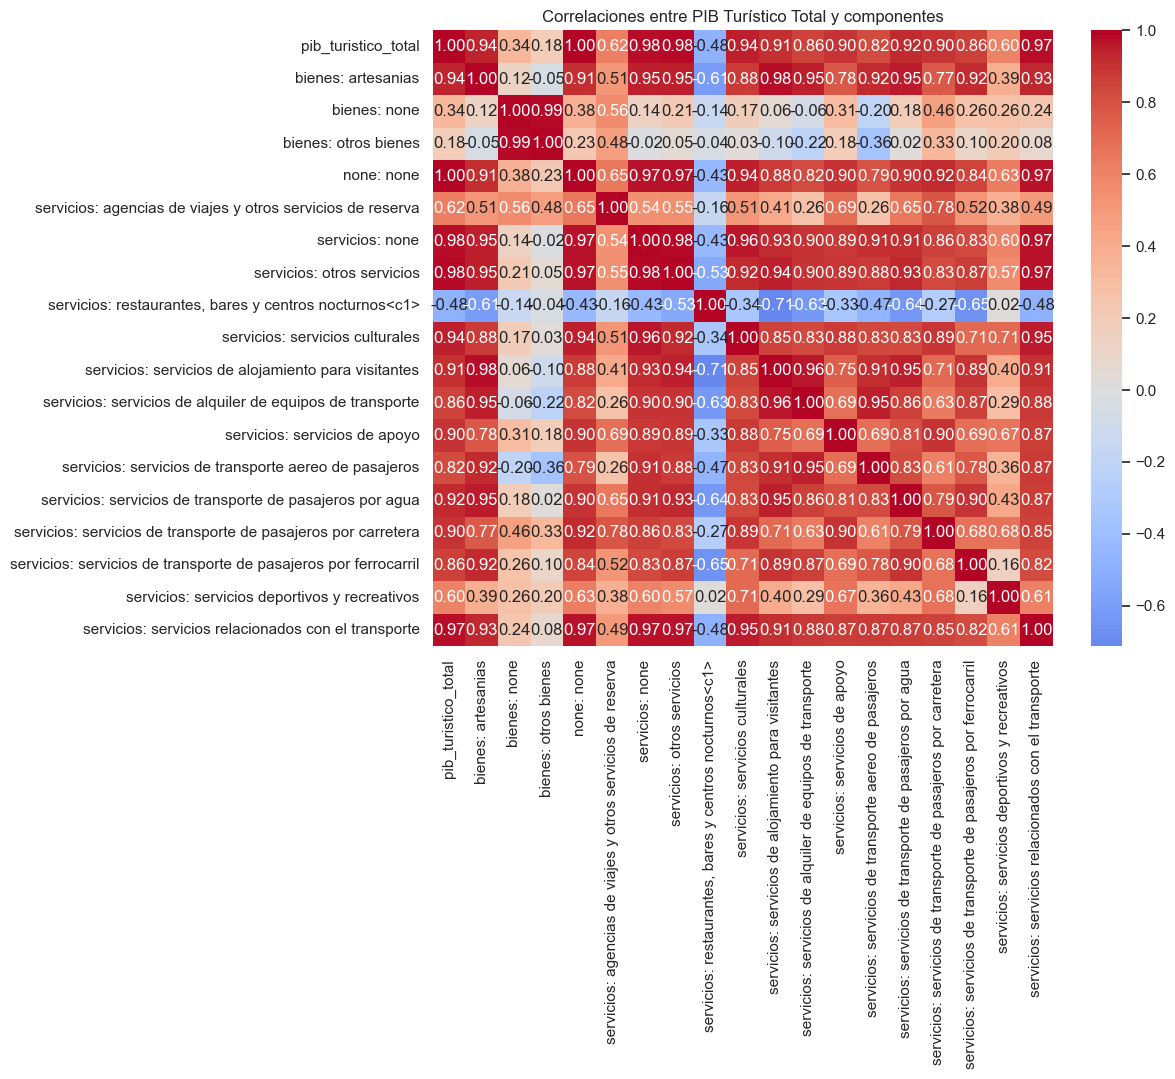

In [239]:
num_dm = dm.select_dtypes(include=[np.number])
corr_matrix = num_dm.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlaciones entre PIB Turístico Total y componentes")
plt.show()

El heatmap muestra las correlaciones de Pearson entre el PIB Turìstico Total y sus componentes. Los valoresse concentran cerca de 1.0, lo que indica una colinealidad muyalta: los componentes estàn fuertemente correlacionados entre si y con el total.

Esto confirma:
Excluir el total como predictor (para evitar colinealidad perfecta).
Usar shares (proporciones) en lugar de niveles brutos.
Aplicar VIF y selecciòn de variables para reduci redundancia.

Construye share = componente / total (estructura del gasto).
Elige un bloque (shares) y deja una share fuera para romper la restricciòn suma=1.
Elimina columnas duplicads o con varianza casi nula, hace un pruning por rango para garantizar rango completo, y podado adicional por |corr|≈1.
Calcula VIF y guarda x_num_clean.
Es la pieza central para manejar colinealidad: el total es suma contable de componentes. Con shares y rpuning aeguramos que el diseño sea estimable e interpretable.

In [240]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

dfm = dm.copy()
y = dfm['pib_turistico_total'].copy()

modo = "B" 
comp_cols = [c for c in dfm.columns if c != 'pib_turistico_total']

if modo == "A":
    k = min(6, len(comp_cols))
    topk = dfm[comp_cols].mean(numeric_only=True).sort_values(ascending=False).head(k).index.tolist()
    X_raw = dfm[topk].copy()

else:  
    for c in comp_cols:
        dfm[f'share_{c}'] = dfm[c] / dfm['pib_turistico_total'].replace(0, np.nan)
    share_cols = [f'share_{c}' for c in comp_cols if f'share_{c}' in dfm.columns]
    if not share_cols:
        raise ValueError("No se pudieron construir columnas de shares.")

    means_sh = dfm[share_cols].mean(numeric_only=True).sort_values(ascending=True)
    drop_share = means_sh.index[0]
    keep_shares = [c for c in share_cols if c != drop_share]

    k = min(6, len(keep_shares))
    keep_shares = dfm[keep_shares].mean(numeric_only=True).sort_values(ascending=False).head(k).index.tolist()
    X_raw = dfm[keep_shares].copy()

X_raw['anio'] = dfm.index.astype(int)

Xv = X_raw.apply(pd.to_numeric, errors='coerce').replace([np.inf, -np.inf], np.nan)
yv = pd.to_numeric(y, errors='coerce').replace([np.inf, -np.inf], np.nan)
valid_idx = Xv.dropna(axis=0).index.intersection(yv.dropna().index)
Xv, yv = Xv.loc[valid_idx].copy(), yv.loc[valid_idx].copy()

const_cols = [c for c in Xv.columns if Xv[c].nunique(dropna=True) <= 1]
if const_cols:
    Xv.drop(columns=const_cols, inplace=True)

def _dedup_columns(X):
    keep = []
    drop = []
    for c in X.columns:
        if not any(np.allclose(X[c].values, X[k].values, equal_nan=True) for k in keep):
            keep.append(c)
        else:
            drop.append(c)
    return X[keep], drop

Xv, dropped_dups = _dedup_columns(Xv)

def full_rank_prune(X, tol=1e-10):
    """Elimina columnas hasta que la matriz con constante sea de rango completo."""
    Xc = sm.add_constant(X, has_constant='add')
    cols = list(Xc.columns) 
    changed = True
    dropped = []
    while changed:
        changed = False
        Xc_mat = Xc.values
        rnk = np.linalg.matrix_rank(Xc_mat, tol=tol)
        if rnk < Xc_mat.shape[1]:
            var = Xc.var(numeric_only=True)
            cand = var.drop(labels=['const'], errors='ignore').idxmin()
            Xc = Xc.drop(columns=[cand])
            dropped.append(cand)
            changed = True
    X_fullrank = Xc.drop(columns=['const'], errors='ignore')
    return X_fullrank, dropped

Xv_full, dropped_lin = full_rank_prune(Xv)

if dropped_dups:
    print("Columnas eliminadas por duplicadas:", dropped_dups)
if dropped_lin:
    print("Columnas eliminadas por dependencia lineal:", dropped_lin)

if Xv_full.shape[1] >= 2:
    corr = Xv_full.corr().abs()
    to_drop = set()
    for i, c1 in enumerate(corr.columns):
        for j, c2 in enumerate(corr.columns):
            if j <= i: 
                continue
            if corr.loc[c1, c2] > 0.999:
                var1, var2 = Xv_full[c1].var(), Xv_full[c2].var()
                drop = c1 if var1 <= var2 else c2
                to_drop.add(drop)
    if to_drop:
        Xv_full = Xv_full.drop(columns=list(to_drop))
        print("Columnas eliminadas por |corr|>0.999:", list(to_drop))

if (Xv_full.shape[0] < 5) or (Xv_full.shape[1] < 2):
    print(" No es posible calcular VIF con la matriz actual (filas o columnas insuficientes).")
    vif_df = pd.DataFrame(columns=['feature','VIF'])
else:
    Xc = sm.add_constant(Xv_full, has_constant='add')
    vifs = []
    for i in range(1, Xc.shape[1]):
        try:
            vifs.append(variance_inflation_factor(Xc.values, i))
        except Exception:
            vifs.append(np.inf)
    vif_df = pd.DataFrame({'feature': Xc.columns[1:], 'VIF': vifs}).sort_values('VIF', ascending=False)

print("=== RESUMEN VIF ===")
display(vif_df)

X_num_clean = Xv_full.copy()
print("X_num_clean shape:", X_num_clean.shape)

Columnas eliminadas por dependencia lineal: ['share_none: none']
=== RESUMEN VIF ===


,feature,VIF
4,share_bienes: none,"1,423.9782"
0,share_servicios: none,760.5048
2,share_servicios: servicios de alojamiento para...,355.4911
3,"share_servicios: restaurantes, bares y centros...",59.8728
5,anio,49.1022
1,share_servicios: otros servicios,15.2898


X_num_clean shape: (31, 6)


Se divide los años en train (80%) y test (20%) respetando el orden temporal, aplica eliminaciòn hacia atràs sobre X_num_clean para quedarse con un conjunto parsimonioso de predictores.
La selecciòn por p-value controla el tamaño del modelo dado que n es pequeño, reduciendo sobreajuste y mejorando generalizaciòn.

In [241]:
years = dfm.index.values
cut = int(0.8*len(years))
train_years, test_years = years[:cut], years[cut:]

X_train, y_train = X_num.loc[train_years], y.loc[train_years]
X_test, y_test   = X_num.loc[test_years], y.loc[test_years]

def backward_elimination(X, y, alpha=0.05):
    X1 = sm.add_constant(X)
    model = sm.OLS(y, X1).fit()
    while True:
        pvals = model.pvalues.drop('const', errors='ignore')
        worst = pvals.idxmax()
        if pvals[worst] > alpha:
            X = X.drop(columns=[worst])
            X1 = sm.add_constant(X)
            model = sm.OLS(y, X1).fit()
        else:
            break
    return X, model

X_sel_train, ols_sel = backward_elimination(X_train, y_train)
selected_cols = X_sel_train.columns.tolist()
print("Variables seleccionadas:", selected_cols)

Variables seleccionadas: ['share_servicios: servicios de alojamiento para visitantes', 'anio']


Se hace ajuste OLS con las columnas seleccionadas, asegura que el orden de columnas en test coincida con el del modelo, calcula RMSE y R² en test.
Porque el OLS es la lìnea base y ademàs permite inferir (coeficientes, p-values, intervalos). Las mètricas en test miden desempeño fuera de muestra, no solo ajuste en train.

In [242]:
X_train1 = sm.add_constant(X_sel_train)
ols_final = sm.OLS(y_train, X_train1).fit()

X_sel_test = X_test[selected_cols]
X_test1 = sm.add_constant(X_sel_test)
y_pred_lin = ols_final.predict(X_test1)

rmse_lin = np.sqrt(np.mean((y_test - y_pred_lin)**2))
r2_lin = 1 - ((y_test - y_pred_lin)**2).sum() / ((y_test - y_test.mean())**2).sum()

print(ols_final.summary())
print(f"\nOLS -> RMSE: {rmse_lin:.3f}, R²: {r2_lin:.3f}")


                             OLS Regression Results                            
Dep. Variable:     pib_turistico_total   R-squared:                       0.958
Model:                             OLS   Adj. R-squared:                  0.954
Method:                  Least Squares   F-statistic:                     237.9
Date:                 Mon, 08 Sep 2025   Prob (F-statistic):           3.74e-15
Time:                         05:54:45   Log-Likelihood:                -315.38
No. Observations:                   24   AIC:                             636.8
Df Residuals:                       21   BIC:                             640.3
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

El modelo lineal (OLS) explica el PIB Turìstico Total usando como predictores:
- share_servicios: alojamiento visitantes
- anio (tendencia temporal)
Resultados:
- El R² = 0.958 indica que el 95.8% de la varianza en el PIB turístico se explica en TRAIN por este modelo.
- El RMSE = 468,752 millones muestra el error promedio de predicción en TEST.
- Los coeficientes son significativos (p-valores < 0.01), lo que indica que tanto la participación de alojamiento como la tendencia temporal tienen efecto real.
- El signo negativo del coeficiente de share_servicios sugiere que, manteniendo constante el tiempo, un aumento en la proporción de alojamiento se asocia con una ligera reducción del total (efecto de composición).
- El coeficiente positivo de `anio` refleja la tendencia creciente del PIB turístico.
- en el conjunto de prueba el R² cae a 0.412, lo que significa que el modelo generaliza de forma moderada. Esto resalta la importancia de evaluar en datos de prueba, pues el ajuste en train puede ser optimista.

El número de condición es alto (2.58e+06), lo que sugiere cierta colinealidad, pero controlada tras la limpieza.

Se hace tèrminos cuadràticos e interacciones razonables(share principal x año), repite selecciòn por p-value y evalùa en test (RMSE, R²).
Captura curvaturas y cambios estructurales moderados, se cumplen interacciones y permite comparar si la no linealidad aporta mejora real sobre OLS.

In [243]:
Xp = X_num[selected_cols].copy()
for c in selected_cols:
    Xp[f'{c}_sq'] = Xp[c]**2

Xp['anio'] = dm.index
Xp['interac'] = Xp[selected_cols[0]] * Xp['anio']

Xp_train, yp_train = Xp.loc[train_years], y.loc[train_years]
Xp_test, yp_test   = Xp.loc[test_years], y.loc[test_years]

Xp_sel, ols_poly = backward_elimination(Xp_train, yp_train)
Xp_test_sel = Xp_test[Xp_sel.columns]

ols_poly_final = sm.OLS(yp_train, sm.add_constant(Xp_sel)).fit()
y_pred_poly = ols_poly_final.predict(sm.add_constant(Xp_test_sel))

rmse_poly = np.sqrt(np.mean((yp_test - y_pred_poly)**2))
r2_poly = 1 - ((yp_test - y_pred_poly)**2).sum() / ((yp_test - yp_test.mean())**2).sum()

print(ols_poly_final.summary())
print(f"\nPolinomio G2 -> RMSE: {rmse_poly:.3f}, R²: {r2_poly:.3f}")


                             OLS Regression Results                            
Dep. Variable:     pib_turistico_total   R-squared:                       0.987
Model:                             OLS   Adj. R-squared:                  0.985
Method:                  Least Squares   F-statistic:                     513.2
Date:                 Mon, 08 Sep 2025   Prob (F-statistic):           4.42e-19
Time:                         05:54:47   Log-Likelihood:                -301.07
No. Observations:                   24   AIC:                             610.1
Df Residuals:                       20   BIC:                             614.8
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.293e+10   1.93e+09      6.69

El modelo polinómico grado 2:
- anio (lineal),
- anio_sq (cuadrático),
- interac (interacción año × otra variable).

resultados:
- El R² = 0.987 sugiere un ajuste casi perfecto en TRAIN, pero en TEST el desempeño cae RMSE = 686,003 millones y R² = -0.259.
- Esto significa que el modelo no generaliza bien: explica el pasado pero falla al predecir fuera de muestra.
- Todos los coeficientes son significativos, pero la presencia del término cuadrático e interacción puede estar sobreajustando la serie temporal (captura ruido en lugar de señal).

- El número de condición es altísimo (5.11e+11), confirmando fuerte colinealidad interna.

Conclusión comparativa:
- El modelo lineal OLS tiene menor error y mejor R² en TEST.
- El modelo polinómico sobreajusta y generaliza peor.
- Por eso, el mejor modelo para este proyecto es el OLS.


Imprime las mètricas (RMSE y R²) de ambos modelos (OLS y Polinomio G2) y selecciona automàticamente el mejor de acuerdo con el menor TMSE en el conjunto de prueba.
La comparaciòn directa con la misma mètrica y en datos no usados para entrenar garantiza una evualaucaciòn justa y objetiva. Esto permite decidir si la complejidad adicional del modelo polinòmico realmente aporta valor, o si el OLS es suficiente. La decisiòn final està sustentada en criterios cuantitativos y no percepciòn subjetiva.

In [244]:
print(f"OLS -> RMSE: {rmse_lin:.3f}, R²: {r2_lin:.3f}")
print(f"Polinomio G2 -> RMSE: {rmse_poly:.3f}, R²: {r2_poly:.3f}")

best = "OLS" if rmse_lin <= rmse_poly else "Polinomio G2"
print("\nMejor modelo:", best)


OLS -> RMSE: 468751.753, R²: 0.412
Polinomio G2 -> RMSE: 686002.822, R²: -0.259

Mejor modelo: OLS


Calcula intervalos de confianza IC para la media e intervalos de predicciòn (IP) para observaciones en test, con get_prediction().summary_frame().
Construye un caso hipotètico con las medianas de train, alineando exactamente las columnas con las del modelo para evitar desajustes. Porque reportar màrgenes de error comunica la incetidumbre del modelo. EL caso hipotètico traduce el modlo a un escenario intuiivo y reproducible.

In [245]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

X_test1 = sm.add_constant(X_sel_test, has_constant='add')
X_test1 = X_test1.reindex(columns=ols_final.params.index, fill_value=0.0).astype(float)

pred_sum = ols_final.get_prediction(X_test1).summary_frame(alpha=0.05)
display(pred_sum[['mean','mean_ci_lower','mean_ci_upper','obs_ci_lower','obs_ci_upper']].head())

if 'selected_cols' not in globals():
    selected_cols = [c for c in X_sel_train.columns]  # respaldo por si renombraste

nuevo = pd.DataFrame(0.0, index=[0], columns=ols_final.params.index)

if 'const' in nuevo.columns:
    nuevo.loc[0, 'const'] = 1.0
for c in selected_cols:
    if c in nuevo.columns:
        med = X_sel_train[c].median()
        med = 0.0 if pd.isna(med) else float(med)
        nuevo.loc[0, c] = med

nuevo = nuevo.astype(float)

pred_nuevo = ols_final.get_prediction(nuevo).summary_frame(alpha=0.05)

m  = float(pred_nuevo['mean'].iloc[0])
mL = float(pred_nuevo['mean_ci_lower'].iloc[0]); mU = float(pred_nuevo['mean_ci_upper'].iloc[0])
oL = float(pred_nuevo['obs_ci_lower'].iloc[0]); oU = float(pred_nuevo['obs_ci_upper'].iloc[0])

print(f"Predicción puntual (millones): {m:,.3f}")
print(f"IC 95% de la media (millones): ({mL:,.3f}, {mU:,.3f})")
print(f"IP 95% observación (millones): ({oL:,.3f}, {oU:,.3f})")


,mean,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
anio,,,,,
2017,"6,599,538.8083","6,469,284.9472","6,729,792.6695","6,296,159.5958","6,902,918.0209"
2018,"6,652,991.8392","6,506,258.4434","6,799,725.2351","6,342,180.6944","6,963,802.9840"
2019,"6,695,088.3588","6,525,842.8858","6,864,333.8318","6,373,037.2628","7,017,139.4548"
2020,"6,311,713.2797","5,869,050.7071","6,754,375.8522","5,791,114.5557","6,832,312.0037"
2021,"6,684,338.7878","6,414,451.7020","6,954,225.8736","6,299,745.6035","7,068,931.9720"


Predicción puntual (millones): 5,754,361.004
IC 95% de la media (millones): (5,660,300.504, 5,848,421.503)
IP 95% observación (millones): (5,464,671.073, 6,044,050.934)


Conclusiones: 
- Huecos (interpolación temporal + mediana),
- Outliers (capado IQR),
- Cualitativas (jerarquía de categorías),
- Colinealidad (no mezclar niveles y shares; dejar una share fuera; poda por rango y correlación),
- Interacciones (modelo polinómico).
- Selección de variables por eliminación hacia atrás: prioriza parsimonia dada la muestra.
- Comparación de modelos: OLS vs polinómico en test (RMSE, R²). Si la mejora del no lineal es marginal, preferimos OLS por interpretabilidad y estabilidad.
- Limitación clave (n pequeño): La serie anual aporta ~30 observaciones. Esto reduce potencia estadística, vuelve más frágil la inferencia y hace más probable la colinealidad.
- usar pocas X significativas, shares en lugar de niveles, selección estricta y validación en test, comunicar IC/IP y no sobreinterpretar coeficientes. 